In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.integrate as sp

Define initial information then transform into log basis

In [85]:
# Perform logarithmic transformation on data to make the distribution more 
# uniform this should improve the stability of the solution as final results 
# have a high spread

# Set log transformed rate constants
k ={
'1':np.log(1.34),
'2':np.log(1.6e9),
'3':np.log(8e3),
'4':np.log(4e7),
'5':np.log(1)
}
# Set initial concentrations in M, log transform means P0 and Q0 cannot be == 0
initial ={
'A0':0.06,
'B0':0.06,
'P0':1e-50,
'Q0':1e-50,
'X0':10**(-9.8),
'Y0':10**(-6.52),
'Z0':10**(-7.32)
}

i_conc = list(initial.values())
i_conc = np.log(i_conc)

In [259]:
class Cell():
    '''
    '''
    def __init__(self):
        #setting conc values for each component, values are already log(conc)
        self.A = i_conc[0]
        self.B = i_conc[1]
        self.P = i_conc[2]
        self.Q = i_conc[3]
        self.X = i_conc[4]
        self.Y = i_conc[5]
        self.Z = i_conc[6]

    # IGNORE, old reaction rates using not log data
    # def dX(self):
    #     dA = -k1*self.A*self.Y
    #     dB = -k3*self.B*self.X
    #     dP = k1*self.A*self.Y +k2*self.X*self.Y
    #     dQ = k4*(self.X)**2
    #     dX = k1*self.A*self.Y -k2*self.X*self.Y +k3*self.B*self.X -k4*(self.X)**2
    #     dY = -k1*self.A*self.Y -k2*self.X*self.Y +k5*self.Z
    #     dZ = k3*self.B*self.X -k5*self.Z
    #     return dA,dB,dP,dQ,dX,dY,dZ
    
    def dXdt(self):
        ### Determine the rates of change for each log value
        # define rates of each reaction
        ln_r1 = k['1'] + self.A + self.Y
        ln_r2 = k['2'] + self.X + self.Y
        ln_r3 = k['3'] + self.B + self.X
        ln_r4 = k['4'] + 2*self.X
        ln_r5 = k['5'] + self.Z

        dA = -np.exp(ln_r1)*np.exp(-self.A)
        dB = -np.exp(ln_r3)*np.exp(-self.B)
        dP = (np.exp(ln_r1)+np.exp(ln_r2))*np.exp(-self.P)
        dQ = np.exp(ln_r4)*np.exp(-self.Q)
        dX = (np.exp(ln_r1)-np.exp(ln_r2)+np.exp(ln_r3)-2*np.exp(ln_r4))*np.exp(-self.X)
        dY = (-np.exp(ln_r1)-np.exp(ln_r2)+np.exp(ln_r5))*np.exp(-self.Y)
        dZ = (np.exp(ln_r3)-np.exp(ln_r5))*np.exp(-self.Z)

        return np.array([dA,dB,dP,dQ,dX,dY,dZ])

    def timestep(self,dt,rtol,atol,Tlast):
        ### step the system forwards by 1 timestep, length dt
        concs = np.array([self.A,self.B,self.P,self.Q,self.X,self.Y,self.Z])
        d = self.dXdt()
        inc = True

        # If error already too high, reduce step below atol and dont increase
        # if max(abs(d)/concs) > rtol/dt or max(abs(d)) > atol/dt:
            # inc = False
        #     dt = atol/(dt*1.5)

        # if the greatest error is less than half the tolerances supplied,
        # increase the timestep until error met
        if any(concs<1e-50):
            inc = False

            
        while inc == True:
            if (max(abs(d)/concs)*(dt*2) < rtol) or (max(abs(d))*(dt*2) < atol):
                dt *= 1.5
                if self.t+dt - Tlast >0.1:
                    inc = False
            else:
                inc = False

        self.A += dt*d[0] 
        self.B += dt*d[1]
        self.P += dt*d[2]
        self.Q += dt*d[3]
        self.X += dt*d[4]
        self.Y += dt*d[5]
        self.Z += dt*d[6]
        return dt

    def run_sim(self,tf,step,rtol,atol):
        '''
        Run the system for time t=0 to t=tf, using a step provided.
        
        Returns a list of [time,x conc,y conc,z conc]
        '''
        self.t = 0
        x_t = list()
        y_t = list()
        z_t = list()
        t_t = list()

        while self.t < tf:
            t_t.append(self.t)
            x_t.append(self.X)
            y_t.append(self.Y)
            z_t.append(self.Z)

            while self.t - t_t[-1] < 0.1:
                deltaTime = self.timestep(step,rtol,atol,t_t[-1])
                self.t += deltaTime
            
        return [t_t,x_t,y_t,z_t]

In [253]:
c = Cell()
output = c.run_sim(90,5e-6,1e-4,1e-4)

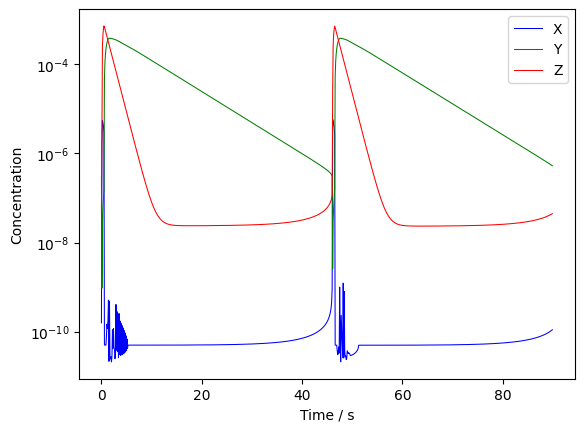

In [254]:
times = output[0]
cX = np.exp(output[1])
cY = np.exp(output[2])
cZ = np.exp(output[3])

# Plot values 
fig = plt.figure()
ax = plt.axes()

ax.set_yscale('log')
# ax.set_xlim(0.5,6)
# ax.set_ylim(10e-12,10e-4)

ax.plot(times,cX,label='X',c='blue',linewidth=0.75)
ax.plot(times,cY,label='Y',c='green',linewidth=0.75)
ax.plot(times,cZ,label='Z',c='red',linewidth=0.75)    

ax.set_ylabel('Concentration')
ax.set_xlabel('Time / s')
plt.legend()

In [260]:
s = Cell()
outlong = s.run_sim(90,1e-6,1e-4,1e-4)

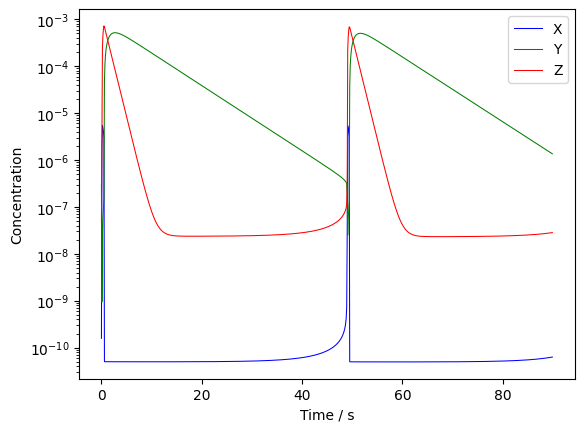

In [261]:
times = outlong[0]
cX = np.exp(outlong[1])
cY = np.exp(outlong[2])
cZ = np.exp(outlong[3])

# Plot values
fig = plt.figure()
ax = plt.axes()

ax.set_yscale('log')
# ax.set_xlim(0.5,6)
# ax.set_ylim(10e-12,10e-4)

ax.plot(times,cX,label='X',c='blue',linewidth=0.75)
ax.plot(times,cY,label='Y',c='green',linewidth=0.75)
ax.plot(times,cZ,label='Z',c='red',linewidth=0.75)    

ax.set_ylabel('Concentration')
ax.set_xlabel('Time / s')
plt.legend()

### Solution using scipy

In [45]:
# define reaction equations in log transform
def dX(t,ABPQXYZ):
    A,B,P,Q,X,Y,Z = ABPQXYZ 
    ln_r1 = k['1'] + A + Y
    ln_r2 = k['2'] + X + Y
    ln_r3 = k['3'] + B + X
    ln_r4 = k['4'] + 2*X
    ln_r5 = k['5'] + Z

    dA = -np.exp(ln_r1)*np.exp(-A)
    dB = -np.exp(ln_r3)*np.exp(-B)
    dP = (np.exp(ln_r1)+np.exp(ln_r2))*np.exp(-P)
    dQ = np.exp(ln_r4)*np.exp(-Q)
    dX = (np.exp(ln_r1)-np.exp(ln_r2)+np.exp(ln_r3)-2*np.exp(ln_r4))*np.exp(-X)
    dY = (-np.exp(ln_r1)-np.exp(ln_r2)+np.exp(ln_r5))*np.exp(-Y)
    dZ = (np.exp(ln_r3)-np.exp(ln_r5))*np.exp(-Z)
    return dA,dB,dP,dQ,dX,dY,dZ

In [250]:
sol = sp.solve_ivp(dX,(0,90),i_conc,method='BDF',first_step=1e-6,atol=1e-5,rtol=1e-4,t_eval=np.linspace(0,90,200))

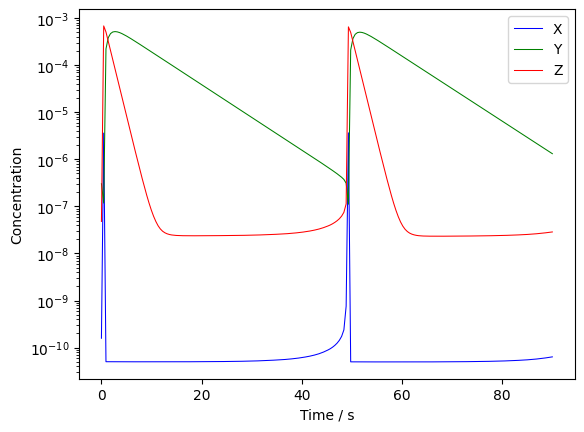

In [251]:
times = sol.t
ys = sol.y

# output is the log of the concentration => convert to plot
cX = np.exp(ys[4])
cY = np.exp(ys[5])
cZ = np.exp(ys[6])

# Plot values obtained with sp.solve_ivp()
fig = plt.figure()
ax = plt.axes()

ax.set_yscale('log')
ax.set_ylabel('Concentration')
ax.set_xlabel('Time / s')

ax.plot(times,cX,label='X',c='blue',linewidth=0.75)
ax.plot(times,cY,label='Y',c='green',linewidth=0.75)
ax.plot(times,cZ,label='Z',c='red',linewidth=0.75)    

plt.legend()

### 1D diffusion problem - outline only, don't try to run it won't work!!

For this really just need to run the system as above in a series of cells, but include a change in concentration dependent on the concentration gradient between two cells

In [ ]:
# Set diffusion constant, chose 1 here as is easiest
diff_constant = 1

In [ ]:
class CellInLine():
    '''
    Define a cell object to be used in a line of diffusing cells
    takes an input concentration array, which is in log(conc) form
    Function steps the cell forwards by 1 step of the reaction
    '''
    def __init__(self,concentrations):
        #set initial concentrations for each cell
        self.species = concentrations
    
    def dXdt(self):
        ### Determine the rates of change for each log value
        # define rates of each reaction

        A,B,P,Q,X,Y,Z = self.species 
        ln_r1 = k['1'] + A + Y
        ln_r2 = k['2'] + X + Y
        ln_r3 = k['3'] + B + X
        ln_r4 = k['4'] + 2*X
        ln_r5 = k['5'] + Z

        dA = -np.exp(ln_r1)*np.exp(-A)
        dB = -np.exp(ln_r3)*np.exp(-B)
        dP = (np.exp(ln_r1)+np.exp(ln_r2))*np.exp(-P)
        dQ = np.exp(ln_r4)*np.exp(-Q)
        dX = (np.exp(ln_r1)-np.exp(ln_r2)+np.exp(ln_r3)-2*np.exp(ln_r4))*np.exp(-X)
        dY = (-np.exp(ln_r1)-np.exp(ln_r2)+np.exp(ln_r5))*np.exp(-Y)
        dZ = (np.exp(ln_r3)-np.exp(ln_r5))*np.exp(-Z)
        return np.array([dA,dB,dP,dQ,dX,dY,dZ])

    def timestep(self,step):
        d = self.dXdt()
        self.species += d*step

In [ ]:
class CellSystem():
    '''
    Class contains Cell objects for the system of a defined size
    Handles diffusion between cells, and timesteps each one
    '''

    def __init__(self,n_cells):

        self.system = list()

        for i in range(0,n_cells):
            self.system.append(CellInLine(i_conc+np.random.rand(1,7)))
    
    def timestep(self,step):
        for item in self.system:
            item.timestep(step)
        
        # Updates each species concentration in accordance with diffusion.
        # Using -1 means the system is being considered to be wrapped rather
        # than have edges.
        #
        # Also must calculate rate for each diffusion before step so they don't
        # effect each other
        rate_of_diffusion = list[]
        for i in range(0,len(self.system)):
            rate_of_diffusion.append((self.system[i].species-self.system[i-1].species)*diff_constant)

        for i in range(0,len(self.system)):
            self.system[i].species -= rate_of_diffusion[i]
            self.system[i-1].species += rate_of_diffusion[i]


In [ ]:
# define a line of 10 cells long
LineOfCells = CellSystem(10)

In [ ]:
# Move that line into the future by a given time, with a given step size
t=0
tf=40
step=1e-6

while t < tf:
    LineOfCells.timestep(step)
    t+=1
